IA & Data science (LU3IN0226) -- 2022-2023
--------
*&copy; Equipe pédagogique: Christophe Marsala, Olivier Schwander, Jean-Noël Vittaut.*

# TD-TME09: algorithme des k-moyennes

L'objectif de ce notebook est d'implémenter l'algorithme des K-moyennes.

<font size="+1" color="RED">**[Q]**</font> **Indiquer dans la boîte ci-dessous vos noms et prénoms :**

ALJANE Noura

<font color="RED" size="+1"><b>[Q]</b></font> **Renommer ce fichier ipython**

**Nom à donner au fichier à poster** : *tme-10-Nom1_Nom2.ipynb* 
- *Nom1* et *Nom2* : noms des membres du binôme
- ne pas compresser ou faire une archive: il faut rendre le fichier ipython tel quel, éventuellement, si vous avez d'autres fichiers vous les rendez séparément.

**Echancier pour la soumission de votre compte-rendu:**
- le compte-rendu d'une séance doit être remis obligatoirement <font color="RED">avant la séance suivante</font>.

**Le compte-rendu est soumis sur la page Moodle.**

## Préparation 

Si vous ne l'avez pas fait lors de la séance précédente, commencer par créer un nouveau fichier de nom `Clustering.py` dans votre répertoire `iads`.
Utilisez les premières lignes du fichier `Classifiers.py` pour débuter votre fichier `Clustering.py`, puis rajoutez dans ce fichier les fonctions écrites dans le TDTME 8:
- normalisation
- dist_euclidienne, dist_manhattan, dist_vect
- centroide, dist_centroides
- initialise, fusionne, clustering_hierarchique
- toutes les autres fonctions écrites

**Remarque**: il est nécessaire d'ajouter des imports utilisés dans le TDTME 8 dans le fichier `Clustering.py`.

In [110]:
# Importation des librairies standards:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
%matplotlib inline  

# Importation de votre librairie iads:
# La ligne suivante permet de préciser le chemin d'accès à la librairie iads
import sys
sys.path.append('../')   # iads doit être dans le répertoire frère du répertoire courant !

# Importation de la librairie iads
import iads as iads

# importation de Classifiers
from iads import Classifiers as cl

# importation de utils
from iads import utils as ut

# importation de evaluation
from iads import evaluation as ev

# importation de Clustering
from iads import Clustering as clust

# commande TRES utile pour recharger automatiquement le code que vous modifiez dans les modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Travail à réaliser
Le travail à faire se décompose en 2 phases :
- dans un premier temps, le travail porte sur la base d'apprentissage <code>base-2D.csv</code> qui contient des exemples décrits dans $R^2$. Ainsi, il est plus aisé de visualiser les résultats des fonctions à écrire ;
- dans un second temps, les fonctions écrites dans la phase précédente sont à utiliser avec la base d'apprentissage `base-Paris.csv`.

Les 2 bases citées ont été fournies dans le TDTME 8, afin de ne pas les recopier, vous pouvez créer un <a href="https://fr.wikipedia.org/wiki/Lien_symbolique">lien symbolique</a> dans votre répertoire `tme-09` pour accéder au répertoire `data` du `tme-08`:

Placez-vous dans votre répertoire `tme-09` dans le terminal puis tapez:

    ln -s ../tme-08/data .
    
Une fois créé, si vous tapez `ls data` dans le répertoire `tme-09` vous aurez l'affichage du contenu du répertoire et les 2 bases seront accessibles directement par `data/base-2D.csv` et `data/base-Paris.csv`.




**Attention**: dans ce notebook, vos fonctions doivent **dès leur création** pouvoir s'appliquer **quelle que soit la dimension** des exemples traités.


### Données d'expérimentation

Commencer par charger le fichier <code>base_2D.csv</code> qui permettra d'expérimenter vos fonctions. Dans ce qui suit, on note <code>data_2D</code> le dataframe qui contient les données de ce fichiers.


In [111]:
data_2D = pd.read_csv("data/base-2D.csv")
data_2D[0:5] 

,X1,X2
0,0.0,4.0
1,1.0,3.5
2,1.0,1.0
3,2.0,1.0
4,2.0,2.0


### Vérification

On vérifie que tout est ok avec la librairie:

In [112]:
data_2D_norm = clust.normalisation(data_2D)
data_2D_norm
#plt.scatter(data_2D_norm['X1'],data_2D_norm['X2'],)

,X1,X2
0,0.000000,0.6
1,0.142857,0.5
2,0.142857,0.0
3,0.285714,0.0
4,0.285714,0.2
5,0.571429,0.6
6,0.571429,0.8
7,0.571429,1.0
8,0.642857,0.0
9,0.642857,1.0


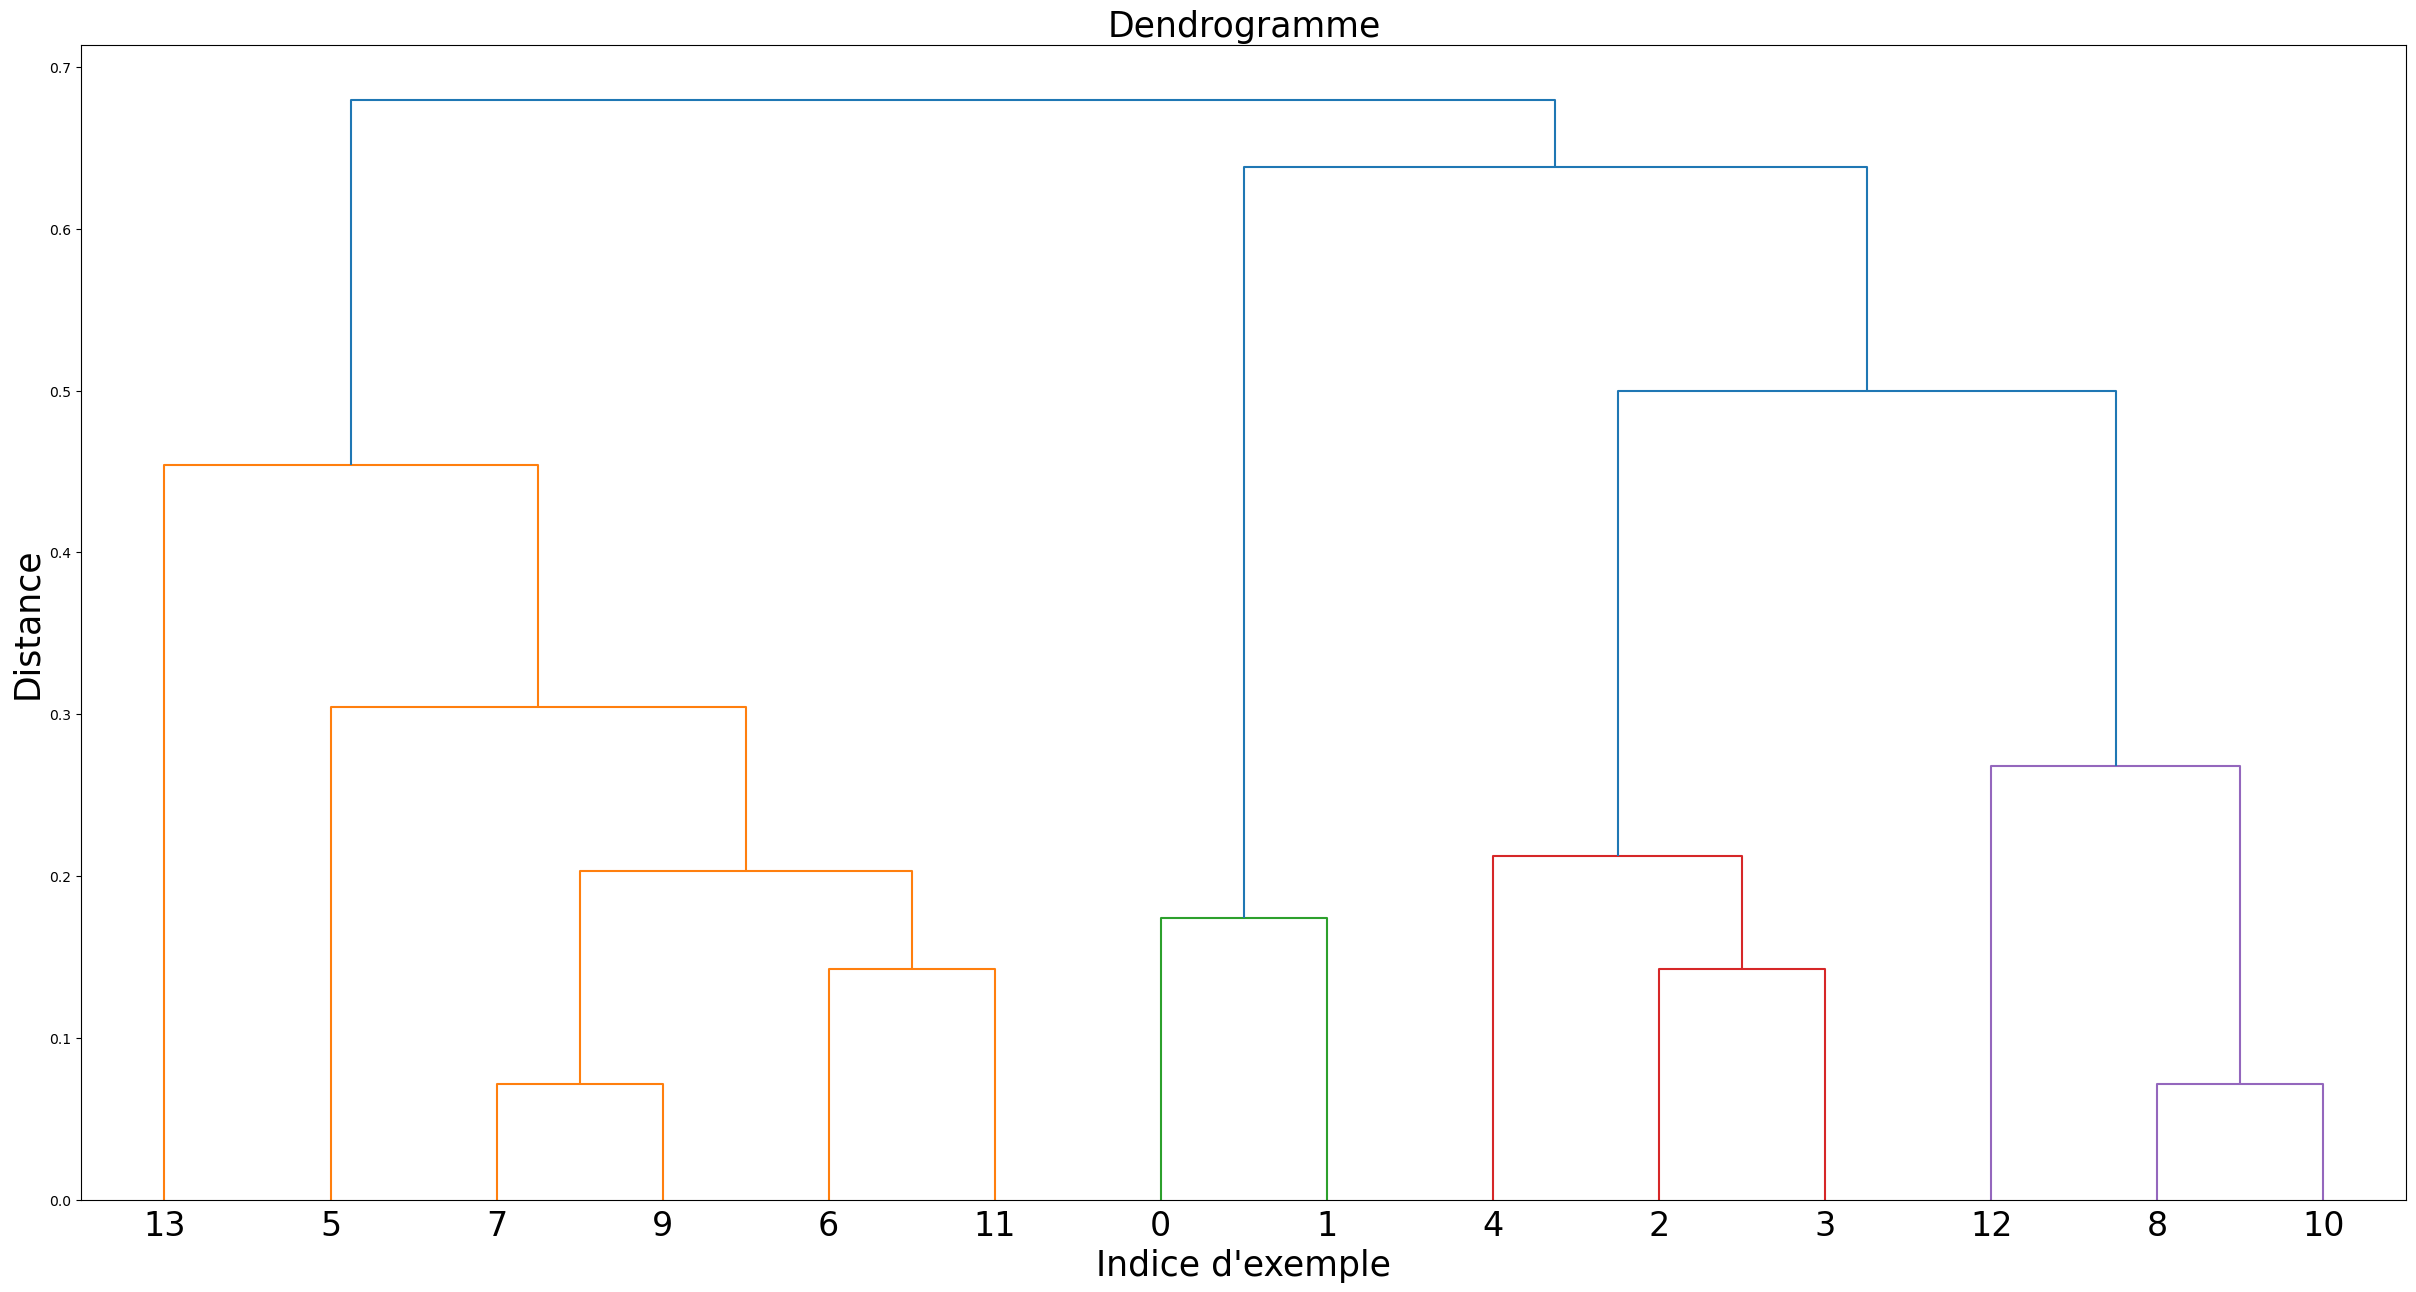

[[8, 10, 0.0714285714285714, 2],
 [7, 9, 0.07142857142857151, 2],
 [2, 3, 0.14285714285714285, 2],
 [6, 11, 0.1428571428571429, 2],
 [0, 1, 0.17437936593905287, 2],
 [15, 17, 0.20316375219039837, 4],
 [4, 16, 0.21237241067597867, 3],
 [12, 14, 0.26811891970176366, 3],
 [5, 19, 0.3047456282855976, 5],
 [13, 22, 0.4542857142857144, 6],
 [20, 21, 0.5000000000000001, 6],
 [18, 24, 0.638139657302555, 8],
 [23, 25, 0.6796842379114776, 14]]

In [113]:
clust.CHA_centroid(data_2D_norm,verbose=False,dendrogramme=True)

In [114]:
print("Centroide de toutes les données de la base:\n",clust.centroide(data_2D_norm))

Centroide de toutes les données de la base:
 X1    0.510204
X2    0.450000
dtype: float64


## Implémentation des k-moyennes

### Inertie d'un cluster
<font size="+1" color="RED"><b>[Q]</b></font> Ecrire la fonction <code>inertie_cluster</code> qui, étant donné un  ensemble d'exemples (sous la forme d'un dataframe ou d'un np.array) contenant au moins 2 exemples, rend la valeur de l'inertie de cet ensemble telle qu'elle a été définie dans le cours.

In [115]:
def inertie_cluster(Ens):
    centre = Ens.mean()
    inertie = np.sum(np.linalg.norm(Ens - centre, axis=1) ** 2)
    return inertie

In [116]:
print(f"inertie de l'ensemble : {inertie_cluster(data_2D_norm):1.4f}")


inertie de l'ensemble : 2.9760


<font size="+1" color="RED"><b>[Q]</b></font>  Ecrire la fonction <code>init_kmeans()</code> qui étant donné un entier $K>1$ et une base d'apprentissage de $n$ exemples rend un np.array composés de $K$ exemples tirés aléatoirement dans la base. On fait l'hypothèse que $K\leq n$.

**Remarque**: étudier les fonctions de la librairie random de Python...


In [175]:

def init_kmeans(K,Ens):
    return np.asarray(random.sample(list(np.array(Ens)), K))
    

In [176]:
np.random.seed(42)
# Par exemple (mais vous ne devriez pas pouvoir retrouver exactement les mêmes !)
Centroides_test = init_kmeans(3,data_2D_norm)
Centroides_test

array([[0.        , 0.6       ],
       [0.57142857, 0.6       ],
       [0.85714286, 0.2       ]])

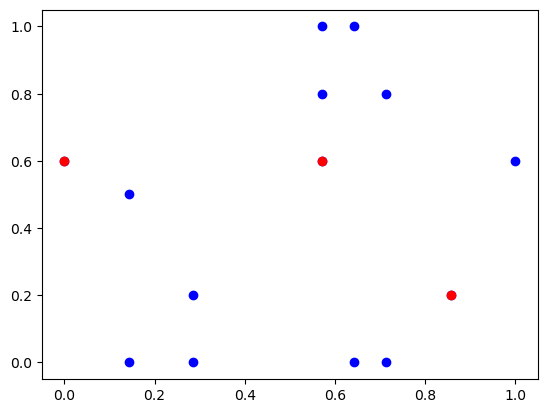

In [177]:
plt.scatter(data_2D_norm['X1'],data_2D_norm['X2'],color='blue')
plt.scatter(Centroides_test[:,0],Centroides_test[:,1],color='red')

In [178]:
from scipy.spatial.distance import cdist

def plus_proche(Exe,Centres):
    return np.argmin(cdist(np.array().reshape(1, -1), C), axis=1)[0]


<font size="+1" color="RED"><b>[Q]</b></font>  Ecrire la fonction <code>plus_proche()</code> qui, étant donné un exemple et un array contenant un ensemble de centroides, rend l'indice du centroide dont l'exemple est le plus proche.
En cas d'égalité de distance, le centroide de plus petit indice est choisi.

In [179]:
Centroides_test[0]

array([0. , 0.6])

In [180]:
def plus_proche(Exe,Centres):
    distances = [clust.dist_euclidienne(Exe, clust.centroide(Centres[i])) for i in range(len(Centres))]
    return np.argmin(distances)

In [181]:
# Exemple (vérifier le résultat avec l'affichage graphique réalisé précédemment):
for i in range(0,len(data_2D_norm)):
    pproche = plus_proche(data_2D_norm.iloc[i],Centroides_test)
    print("L'exemple ",i," est le plus proche du centroide ",pproche)

L'exemple  0  est le plus proche du centroide  0
L'exemple  1  est le plus proche du centroide  0
L'exemple  2  est le plus proche du centroide  0
L'exemple  3  est le plus proche du centroide  0
L'exemple  4  est le plus proche du centroide  0
L'exemple  5  est le plus proche du centroide  1
L'exemple  6  est le plus proche du centroide  1
L'exemple  7  est le plus proche du centroide  1
L'exemple  8  est le plus proche du centroide  0
L'exemple  9  est le plus proche du centroide  1
L'exemple  10  est le plus proche du centroide  0
L'exemple  11  est le plus proche du centroide  1
L'exemple  12  est le plus proche du centroide  2
L'exemple  13  est le plus proche du centroide  1


### Matrice d'affectation

Etant donné une base d'apprentissage, on représente une partition de cette base en K clusters à l'aide d'une matrice U contenant n lignes (une par exemple) et K colonnes (une par cluster) et telle que les contraintes suivantes sont vérifiées: 
- U[i,j] = 1 si l'exemple i appartient au cluster j
- U[i,j] = 0 si l'exemple i n'appartient pas au cluster j
- un exemple appartient à un et un seul cluster
- un cluster contient au moins un exemple

On appelle **matrice d'affectation** une telle matrice U.


<font size="+1" color="RED"><b>[Q]</b></font>  Donner une expression mathématique (pas du Python) des 2 dernières contraintes que vérifie une matrice d'affectation.

### Implémentation en Python
Nous utilisons un dictionnaire pour représenter d'une matrice d'affectation: 
- les clés de ce dictionnaire correspondent aux $K$ indices des clusters
- les valeurs correspondent à des listes d'indices d'exemples (leur indice dans la base d'apprentissage)

Dans tout ce qui suit, une "matrice d'affectation" sera un tel dictionnaire.


<font size="+1" color="RED"><b>[Q]</b></font>  Ecrire la fonction <code>affecte_cluster()</code> qui, étant donné une base d'apprentissage et un ensemble de $K$ centroïdes, rend la matrice d'affectation des exemples de la base aux clusters représentés par chaque centroïde.

In [182]:
from scipy.spatial.distance import cdist

def affecte_cluster(Base,Centres):
    Y = np.argmin(cdist(Base, Centres), axis=1)
    return {c:list(np.where(Y==c)[0]) for c in range(len(Centres))}

In [183]:
DictAffect = affecte_cluster(data_2D_norm, Centroides_test)
DictAffect

{0: [0, 1, 2, 4], 1: [5, 6, 7, 9, 11], 2: [3, 8, 10, 12, 13]}

### Ensemble des centroides
Grâce à la matrice d'affectation, on peut maintenant trouver les nouveaux centroides. Ceux-ci sont déterminés en prenant les moyennes des ensembles des exemples qui sont affectés au même cluster.

<font size="+1" color="RED"><b>[Q]</b></font>  Ecrire la fonction <code>nouveaux_centroides()</code> qui, étant donné une base d'apprentissage et une matrice d'affectation, rend l'ensemble des nouveaux centroides obtenus.

In [ ]:
def nouveaux_centroides(Base,U):

############# A COMPLETER 

In [16]:
data_2D_norm.iloc[DictAffect[0]]

,X1,X2
7,0.571429,1.0
9,0.642857,1.0


In [17]:
clust.centroide(data_2D_norm.iloc[DictAffect[0]])

X1    0.607143
X2    1.000000
dtype: float64

In [18]:
nouveaux_centroides(data_2D_norm, DictAffect)

array([[0.60714286, 1.        ],
       [0.7244898 , 0.42857143],
       [0.17142857, 0.26      ]])

### Inertie globale d'une partition

<font size="+1" color="RED"><b>[Q]</b></font>  En utilisant la fonction `inertie_cluster()`, écrire la fonction `inertie_globale()` qui, étant donné une base d'apprentissage et une matrice d'affectation, rend la valeur de l'inertie globale du partitionnement correspondant.


In [ ]:
def inertie_globale(Base, U):
    
############# A COMPLETER 

In [20]:
print(f'Inertie globale: {inertie_globale(data_2D_norm,DictAffect):1.4f}')

Inertie globale: 1.2732


### Algorithme des K-moyennes

<font size="+1" color="RED"><b>[Q]</b></font>  En utilisant les fonctions précédentes, implémenter l'algorithme des K-moyennes.
Pour cela, écrire une fonction <code>kmoyennes()</code> qui prend en argument un entier $K>1$, une base d'apprentissage, ainsi que deux nombres: un réel *epsilon*$>0$ et un entier *iter_max*$>1$, et qui rend un ensemble de centroides et une matrice d'affectation.

Le réel *epsilon* sert de critère de convergence, et l'entier *iter_max* est utilisé pour fixer un nombre d'itérations maximal servant à arrêter le calcul.

In [ ]:
def kmoyennes(K, Base, epsilon, iter_max):

############# A COMPLETER 

In [22]:
np.random.seed(42)   # supprimer cette ligne une fois la mise au point terminée

les_centres, l_affectation = kmoyennes(2, data_2D_norm, 0.05, 100)

print("Affichage des centres: ",les_centres)
print("Affichage des affectations: ",l_affectation)

iteration 1 Inertie : 2.2482 Difference: 1.1982
iteration 2 Inertie : 1.5128 Difference: 0.7354
iteration 3 Inertie : 1.3921 Difference: 0.1207
iteration 4 Inertie : 1.3921 Difference: 0.0000
Affichage des centres:  [[0.67857143 0.8       ]
 [0.38392857 0.1875    ]]
Affichage des affectations:  {0: [5, 6, 7, 9, 11, 13], 1: [0, 1, 2, 3, 4, 8, 10, 12]}


In [23]:
np.random.seed(42)   # supprimer cette ligne une fois la mise au point terminée

les_centres, l_affectation = kmoyennes(3, data_2D_norm, 0.05, 100)

print("Affichage des centres: ",les_centres)
print("Affichage des affectations: ",l_affectation)

iteration 1 Inertie : 1.2732 Difference: 0.2232
iteration 2 Inertie : 0.9095 Difference: 0.3637
iteration 3 Inertie : 0.8127 Difference: 0.0968
iteration 4 Inertie : 0.8127 Difference: 0.0000
Affichage des centres:  [[0.61428571 0.84      ]
 [0.80357143 0.2       ]
 [0.17142857 0.26      ]]
Affichage des affectations:  {0: [5, 6, 7, 9, 11], 1: [8, 10, 12, 13], 2: [0, 1, 2, 3, 4]}


On peut réaliser un affichage couleur des centroïdes trouvés:

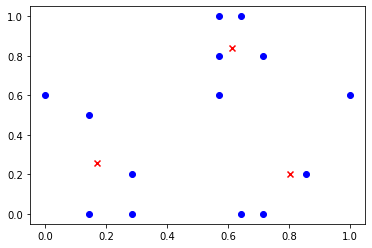

In [24]:
plt.scatter(data_2D_norm['X1'],data_2D_norm['X2'],color='b')
plt.scatter(les_centres[:,0],les_centres[:,1],color='r',marker='x')

<font size="+1" color="RED"><b>[Q]</b></font>  Ecrire la fonction <code>affiche_resultat()</code> qui permet d'afficher le résultat de l'algorithme en utilisant des couleurs différentes pour les clusters trouvés (pour faire simple, on peut ne considèrer que le cas où K est inférieur à 20).

*Remarque*: La librairie matplotlib permet de manipuler aisément des couleurs:
http://matplotlib.org/api/cm_api.html

Par exemple, on peut utiliser la table des couleurs (colormap) de nom `tab20` qui contient 20 couleurs différentes.

nombre de couleurs différentes 20


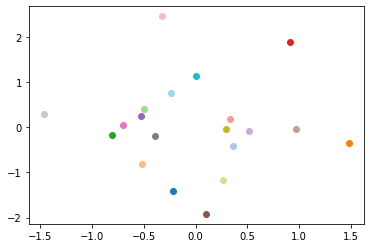

In [29]:
# Librairie pour manipuler les colormaps:
import matplotlib.cm as cm

# on transforme le colormap en couleurs utilisable par plt.scatter:
couleurs = cm.tab20(np.linspace(0, 1, 20))

print("nombre de couleurs différentes",len(couleurs))

# Pour voir ces couleurs, on va afficher 20 points aléatoirement définis:
x = np.random.randn(len(couleurs))
y = np.random.randn(len(couleurs))       

for (x,y,c) in zip(x,y,couleurs):
    plt.scatter(x, y, color=c)
    

In [ ]:
def affiche_resultat(Base,Centres,Affect):

############# A COMPLETER 

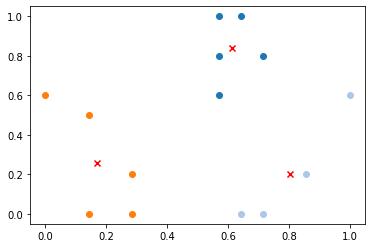

In [28]:
affiche_resultat(data_2D_norm,les_centres,l_affectation)

# Remarque:
#  - les centres sont représentés par des croix rouges


## Evaluation du résultat d'un clustering

Cette partie est à faire après le cours 9 où l'évaluation de clustering sera vue.

<font size="+1" color="RED"><b>[Q]</b></font> Implémenter les indices vus en cours: 
- index de Dunn
- index de Xie-Beni


## Expérimentations

<font size="+1" color="RED"><b>[Q]</b></font>  Expérimenter l'algorithme des k-moyennes sur les données. Etudier l'impact du choix de $K$ sur l'inertie globale finale. Faire de même en relançant plusieurs fois l'algorithme avec la même valeur de $K$, en modifiant la valeur de epsilon ou de max_iter, etc.

Vous utiliserez les indices d'évaluation pour comparer les partitions. Par exemple, il sera intéressant d'afficher la courbe de variation de ces indices en fonctions de $K$.

<font size="+1" color="RED"><b>[Q]</b></font>  Expérimenter l'algorithme des k-moyennes sur les données de la base `base_Paris` vue dans le TDTME précédent.

Vous pouvez afficher les résultats obtenus avec le clustering hiérarchique afin de trouver une bonne valeur pour $K$.


## Questions de cours (à faire sur feuille)

Pour vous entraîner sans machine...

<font size="+1" color="RED"><b>[Q]</b></font>  On considère un ensemble fini $U$ d'éléments. 
- donner la fonction caractéristique de $U$
- donner la fonction caractéristique de l'ensemble vide
- soit $E$ et $F$ deux sous-ensembles de $U$ définis par leurs fonctions caractéristiques $\chi_E$ et $\chi_F$. En déduire les fonctions caractéristiques de $E\cup F$, de $E\cap F$ et de $E^{c}$. *(indice: penser au min et au max)*

<font size="+1" color="RED"><b>[Q]</b></font> Rappeler la définition d'une partition $P$ d'un ensemble $X$ en $K$ sous-ensembles. 

<font size="+1" color="RED"><b>[Q]</b></font>  Appliquer, à la main, l'algorithme des K-moyennes sur les données des questions 2 et 3 de l'exercice 2 du sujet de TD 8, en utilisant d'abord $K=2$, puis $K=3$. Dans chacun des cas, réaliser au maximum 10 itérations de l'algorithme ($t_{max}=10$).
Comparer les résultats obtenus.


---